---
title: "1D Forward Simulation for a Single Sounding"
authors:
  - id: devincowan
---

```{admonition} Introductory notebook
:class: hint
This tutorial teaches basic functionality within SimPEG and is a good entry point for new users.
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

**Keywords:** TDEM, forward simulation, waveforms, 1D sounding, wires mapping.

</br>

**Summary:** In this tutorial, we present the fundamentals of simulating TDEM data in SimPEG. We use the module [simpeg.electromagnetics.time_domain](xref:simpeg#simpeg.electromagnetics.time_domain) to simulate TDEM data for a 1D sounding. The [Simulation1DLayered](xref:simpeg#simpeg.electromagnetics.time_domain.simulation_1d.Simulation1DLayered) class is used to solve the problem via a semi-analytic Hankel transform solution. Note that most of what is learned here can be applied to simulating 3D TDEM data.

The tutorial is organized into 3 parts. In **part 1,** we focus on the most fundamental aspects of simulating TDEM data. For a step-off waveform, we simulate TDEM data for a conductive and non-permeable layered Earth. In **part 2,** we demonstrate how to include dispersive electromagnetic properties in the 1D TDEM simulation. And in **part 3,** we demonstrate how data can be simulated for user-specified transmitter waveforms.

</br>

**Learning Objectives:**

- The fundamentals of simulating TDEM data with SimPEG.
- Understanding the way in which TDEM surveys are created in SimPEG, which includes:
    - Defining receivers
    - Defining controlled sources
    - Organizing sources and receivers into a survey object
- Defining the Earth's electrical properties in terms of conductivity OR resistivity.
- The ways in which we can define 1D layered Earth models.
- Simulating TDEM data for different transmitter waveforms
- Simulating TDEM data for dispersive electromagnetic properties (i.e. induced polarization, superparamagnetism)

## Importing Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to TDEM is imported from [simpeg.electromagnetics.time_domain](xref:simpeg#simpeg.electromagnetics.time_domain).
We also import some useful utility functions from [simpeg.utils](xref:simpeg#simpeg.utils).

In [1]:
# SimPEG functionality
import simpeg.electromagnetics.time_domain as tdem
from simpeg import maps
from simpeg.utils import plot_1d_layer_model

# Common Python functionality
import os
import numpy as np
from scipy.constants import mu_0
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({"font.size": 14})

write_output = False  # Optional

## Part 1: Step-Off Response for a Conductive Layer

In this part of the tutorial, we focus on the most fundamental aspects of simulating TDEM data in SimPEG. Here, the survey consists of a single circular loop located 1 m above the Earth's surface. The vertical B-field is simulated at the loop's centre for a step-off waveform.

### Defining the Survey

TDEM surveys within SimPEG require the user to create and connect four types of objects:

- **receivers:** There are a multitude of TDEM receiver classes within SimPEG, each of which is used to simulate data corresponding to a different field measurement; e.g. [PointMagneticField](xref:simpeg#simpeg.electromagnetics.time_domain.receivers.PointMagneticField), [PointMagneticFluxTimeDerivative](xref:simpeg#simpeg.electromagnetics.time_domain.receivers.PointMagneticFluxTimeDerivative) and [PointElectricField](xref:simpeg#simpeg.electromagnetics.time_domain.receivers.PointElectricField). The properties for each TDEM receiver object generally include: the orientation of the field being measured (x, y, z, other), the time channels, the data type, and one or more associated observation locations.
- **sources:** There are a multitude of TDEM source classes within SimPEG, each of which corresponds to a different geometry; e.g. [MagDipole](xref:simpeg#simpeg.electromagnetics.time_domain.sources.MagDipole) and [LineCurrent](xref:simpeg#simpeg.electromagnetics.time_domain.sources.LineCurrent). Source classes generally require the user to define the current waveform, location and geometry.
- **waveforms:** The waveform defining the time-dependent current in the source is defined by an object in SimPEG. Some waveform classes include [StepOffWaveform](xref:simpeg#simpeg.electromagnetics.time_domain.sources.StepOffWaveform), [VTEMWaveform](xref:simpeg#simpeg.electromagnetics.time_domain.sources.VTEMWaveform) and [RawWaveform](xref:simpeg#simpeg.electromagnetics.time_domain.sources.RawWaveform)
- **survey:** The object which stores and organizes all of the sources and receivers.

For a full list of *source types*, *waveform types* and *receiver types*, please visit API documentation for [simpeg.electromagnetics.time_domain](xref:simpeg#simpeg.electromagnetics.time_domain).

**Topography:** When generating the survey for a 1D forward simulation, sources and receivers **must** be located **above** the Earth's surface. By default, the Earth's surface is at z = 0 m when defining the 1D simulation. So for 1D FDEM problems, it is easiest to define the z-locations of all sources and receivers as flight heights.

**For this tutorial**, the survey consists of a circular source loop 1 m above the surface that uses a step-off waveform. The vertical component of the magnetic flux density is measured at the loop's center at a number of time channels.

In [7]:
# Source properties
source_location = np.array([0.0, 0.0, 30.0])  # (3, ) numpy.array_like
source_orientation = "z"  # "x", "y" or "z"
source_current = 1.0  # maximum on-time current (A)
source_radius = 10.0  # source loop radius (m)

# Receiver properties
receiver_locations = np.array([0.0, 0.0, 30.0])  # or (N, 3) numpy.ndarray
receiver_orientation = "z"  # "x", "y" or "z"
times = np.logspace(-5, -2, 31)  # time channels (s)

In [8]:
times * 1e3

array([ 0.01      ,  0.01258925,  0.01584893,  0.01995262,  0.02511886,
        0.03162278,  0.03981072,  0.05011872,  0.06309573,  0.07943282,
        0.1       ,  0.12589254,  0.15848932,  0.19952623,  0.25118864,
        0.31622777,  0.39810717,  0.50118723,  0.63095734,  0.79432823,
        1.        ,  1.25892541,  1.58489319,  1.99526231,  2.51188643,
        3.16227766,  3.98107171,  5.01187234,  6.30957344,  7.94328235,
       10.        ])

A waveform must be assigned as a property of each TDEM source object. Here, we define a step-off waveform. By default, the off-time for the step-off waveform begins at 0 s. However, the keyword argument ``off_time`` can be used to change the start of the off-time.

In [10]:
stepoff_waveform = tdem.sources.StepOffWaveform(off_time=0.0)
# stepoff_waveform = tdem.sources.PiecewiseLinearWaveform(off_time=0.0)

The most general way to generate TDEM surveys is to loop over all sources. A new source object must be created whenever the source location and/or geometry differs. For each source, we define and assign the associated receivers. A different receiver object must be created whenever geometry, data type and/or time channels differ. However, identical data being collected at a multitude of observation locations can be defined using a single receiver object.

**For this tutorial**, we only have a single source. And this source only has a single receiver. More complicated survey geometries are used in the [3D Forward Simulation of TDEM Data on Cylindrical Mesh for a Galvanic Source](fwd_tdem_cyl.ipynb) and [Forward Simulation of 3D Airborne TDEM Data on a Tree Mesh](fwd_tdem_3d.ipynb) tutorials. These tutorials demonstrate the more general construction of TDEM surveys.

In [12]:
receiver_orientation

'z'

In [15]:
# Define receiver list. In our case, we have only a single receiver for each source.
# When simulating the response for multiple data types for the same source,
# the list consists of multiple receiver objects.
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_locations, times, orientation=receiver_orientation
    )
)

# Define source list. In our case, we have only a single source.
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=stepoff_waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)

### Defining a 1D Layered Earth and the Model

In SimPEG, a 1D layered Earth is defined by the set of layer thicknesses and the physical properties for each layer. Thicknesses and physical property values are defined from the top layer down. If we have N layers, we define N physical property values and N-1 layer thicknesses. The lowest layer is assumed to extend to infinity. In the case of a halfspace, the layer thicknesses would be an empty array.

In [38]:
# Layer conductivities
layer_resistivity = np.r_[10, 5, 600, 700]
layer_resistivity_bg = np.r_[10, 5, 5, 700]

# Layer thicknesses
layer_thicknesses = np.r_[10, 15, 70]

# Number of layers
n_layers = len(layer_resistivity)

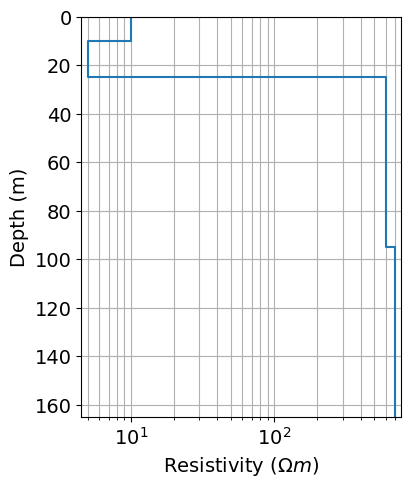

In [23]:
fig = plt.figure(figsize=(4, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax1 = plot_1d_layer_model(layer_thicknesses, layer_resistivity, scale="log", ax=ax1)
ax1.grid(which="both")
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
plt.show()

### Models and Mappings for 1D Simulations

In SimPEG, the term 'model' is not necessarily synonymous with a set of physical property values. For example, the model may be defined as the logarithms of the physical property values, or be the parameters defining a layered Earth geometry. Models in SimPEG are 1D [numpy.ndarray](xref:numpy#numpy.ndarray) whose lengths are equal to the number of model parameters. For 1D TDEM simulations, we can characterize the Earth's electric properties according to electrical conductivity or electrical resistivity.

Classes within the ``simpeg.maps`` module are used to define the mapping that connects the model to the parameters required to run the 1D TDEM simulation; e.g. layer conductivities/resistivities, magnetic permeabilities and/or layer thicknesses. In this part of the tutorial, we demonstrate 2 types of mappings and models that may be used for 1D TDEM simulation.

**1. Conductivity model:** For forward simulation, the easiest approach is to define the model as the layer conductivities and set the layer thicknesses as a static property of the 1D simulation. In this case, the mapping from the model to the conductivities is defined using the [simpeg.maps.IdentityMap](xref:simpeg#simpeg.maps.IdentityMap) class.

**2. Parametric layered Earth model:** In this case, the model parameters are log-resistivities and layer thicknesses. We therefore need a mapping that extracts log-resistivities from the model and converts them into resistivities, and a mapping that extracts layer thicknesses from the model. For this, we require the [simpeg.maps.Wires](xref:simpeg#simpeg.maps.Wires) mapping and [simpeg.maps.ExpMap](xref:simpeg#simpeg.maps.ExpMap) mapping classes. Note that successive mappings can be chained together using the $*$ operator.

In [26]:
# Define model and mapping for a conductivity model.
conductivity_model = layer_conductivities.copy()
conductivity_map = maps.IdentityMap(nP=n_layers)

# Define model and mappings for the parametric model.
# Note the ordering in which you defined the model parameters and the
# order in which you defined the wire mappings matters!!!
parametric_model = np.r_[layer_thicknesses, np.log(1 / layer_conductivities)]
wire_map = maps.Wires(("thicknesses", n_layers - 1), ("log_resistivity", n_layers))
thicknesses_map = wire_map.thicknesses
log_resistivity_map = maps.ExpMap() * wire_map.log_resistivity

### Defining the Forward Simulation

In SimPEG, the physics of the forward simulation is defined by creating an instance of an appropriate simulation class. Here, we use the [Simulation1DLayered](xref:simpeg#simpeg.electromagnetics.time_domain.Simulation1DLayered) which simulates the data according to a 1D Hankel transform solution. To fully define the forward simulation, we need to connect the simulation object to:

- the survey
- the layer thicknesses
- the physical properties of the layers (e.g. conductivity)

This is accomplished by setting each one of the aforementioned items as a property of the simulation object. Since the parameters defining the model in each case are different, we must define a separate simulation object for each case.

**1. Conductivity model simulation:** Here, the model parameters are the layer conductivities. ``sigmaMap`` is used to define the mapping from the model to the layer conductivities. And ``thicknessess`` is used to set the layer thicknesses as a static property of the simulation.

**2. Parametric model simulation:** Here, the model consists of the layer thicknesses and log-resistivities. Because we are now working with electric resistivity, ``rhoMap`` is used to define the mapping for the Earth's electrical properties; i.e. model parameters to layer resistivities. And ``thicknessesMap`` is used to define the mapping from the model to the layer thicknesses.

In [27]:
simulation_parametric = tdem.simulation_1d.Simulation1DLayered(
    survey=survey,
    rhoMap=log_resistivity_map,
    thicknessesMap=thicknesses_map,
)

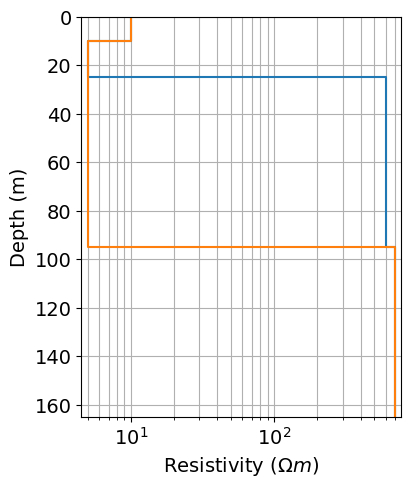

In [40]:
fig = plt.figure(figsize=(4, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax1 = plot_1d_layer_model(layer_thicknesses, layer_resistivity, scale="log", ax=ax1)
ax1 = plot_1d_layer_model(layer_thicknesses, layer_resistivity_bg, scale="log", ax=ax1)
ax1.grid(which="both")
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
plt.show()

In [56]:
layer_resistivity = np.r_[10, 5, 600, 700]
layer_resistivity_bg = np.r_[10, 5, 5, 700]


In [57]:
m = np.r_[layer_thicknesses, np.log(layer_resistivity)]
m_bg= np.r_[layer_thicknesses, np.log(layer_resistivity_bg)]

dpred = simulation_parametric.dpred(m)
dpred_bg = simulation_parametric.dpred(m_bg)

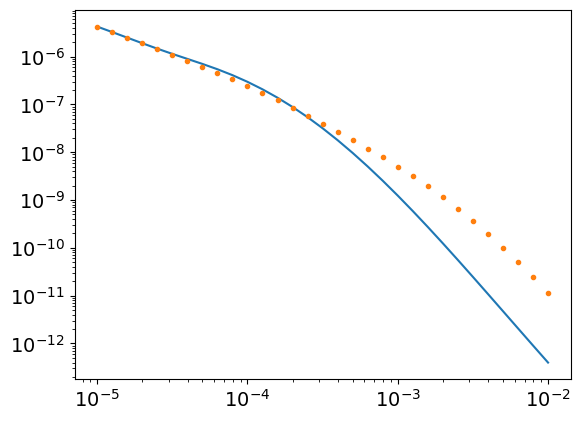

In [58]:
plt.loglog(times, -dpred)
plt.loglog(times, -dpred_bg, '.')